In [7]:
# check if this instance of the notebook already has files present
# and thus determine which steps required prior to reading in file and handling the data
!ls


data	   spark-3.3.2-bin-hadoop3	  week5_cycleHire.ipynb
models	   spark-3.3.2-bin-hadoop3.tgz	  week5_wordcount.ipynb
notebooks  spark-3.3.2-bin-hadoop3.tgz.1  week6_cycleHire2.ipynb
README.md  venv				  week6_cycleHire3.ipynb


In [8]:
# set-up spark (NB if Apache amend versions on download site we will need to amend path in wget command)
## NOTE that this version would make use of Hadoop if installed BUT that HDFS & Hadoop is not installed on our Colab
## (we are only using a single node (probably as a VM) so we will not be able to benefit from parallelism)
!clear
!echo welcome

!rm -f spark-3.3.[01]-bin-hadoop3.tgz* 
!rm -rf spark-3.3.[01]-bin-hadoop3

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xf spark-3.3.2-bin-hadoop3.tgz

!ls -alt
print("standalone Spark is now installed")

welcome
/bin/bash: line 1: apt-get: command not found
--2023-05-24 14:48:52--  https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving downloads.apache.org (downloads.apache.org)... 2a01:4f8:10a:201a::2, 2a01:4f9:3a:2c57::2, 88.99.95.219, ...
Connecting to downloads.apache.org (downloads.apache.org)|2a01:4f8:10a:201a::2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz.2’

spark-3.3.2-bin-had 100%[===================>] 285.49M  4.23MB/s    in 77s     

2023-05-24 14:50:10 (3.70 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz.2’ saved [299360284/299360284]

total 877108
drwxr-xr-x 1 seirra seirra       470 May 24 14:48 .
-rw-r--r-- 1 seirra seirra     15838 May 24 14:48 week5_cycleHire.ipynb
drwxr-xr-x 1 seirra seirra       224 May 24 14:38 .idea
drwxr-xr-x 1 seirra seirra       148 May 24 14:14 .git
drwxr-xr-x

In [9]:
# init spark (ensure SPARK_HOME set to same version as we download earlier)
!pip3 install findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/opt/apache-spark"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
# the next line gives us 'local' mode. try 'local[2]' to use 2 cores or 'master:NNNN' to run on Spark standalone cluster at port NNNN
spark_conf = SparkConf().setMaster('local[2]').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)
# see what we have by examining the Spark User Interface
from pyspark.sql import *
from pyspark.sql.functions import *
SparkSession.builder.getOrCreate()
## 


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/24 14:50:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
## this is how one could upload a file into colab using the colab GUI (uncomment both lines if want to try it)

#from google.colab import files
#files.upload()


In [11]:
# get file for given year from TfL open data
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip

--2023-05-24 14:50:18--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 64:ff9b::6810:650d, 64:ff9b::6810:640d, 104.16.100.13, ...
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|64:ff9b::6810:650d|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M  2.13MB/s    in 2m 27s  

2023-05-24 14:52:46 (1.46 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data

In [12]:
# at this point we have Spark initialised and we have a number of CSV files. 
# NB you can try also download the zipfile to your host machine and try opening in Excel (Win)
# (in Linux, easiest to open a file manager GUI then double-click on .csv file to open associated spreadsheet app)

In [13]:
# read in file
!ls
file="./1. Journey*csv"
spark = SparkSession.builder.appName("bikes").getOrCreate()
j_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(file))

# show top 10
j_df.show(10)

'10a. Journey Data Extract 14Sep14-27Sep14.csv'
'10b. Journey Data Extract 28Sep14-11Oct14.csv'
'11a. Journey Data Extract 12Oct14-08Nov14.csv'
'11b. Journey Data Extract 12Oct14-08Nov14.csv'
'12a. Journey Data Extract 09Nov14-06Dec14.csv'
'12b. Journey Data Extract 09Nov14-06Dec14.csv'
'13a. Journey Data Extract 07Dec14-21Dec14.csv'
'13b. Journey Data Extract 22Dec14-03Jan15.csv'
'14. Journey Data Extract 08Dec13-04Jan14.csv'
'1. Journey Data Extract 05Jan14-02Feb14.csv'
'2. Journey Data Extract 03Feb14-01Mar14.csv'
'3. Journey Data Extract 02Mar14-31Mar14.csv'
'4. Journey Data Extract 01Apr14-26Apr14.csv'
'5. Journey Data Extract 27Apr14-24May14.csv'
'6. Journey Data Extract 25May14-21Jun14.csv'
'7. Journey Data Extract 22Jun14-19Jul14.csv'
'8a Journey Data Extract 20Jul14-31Jul14.csv'
'8b Journey Data Extract 01Aug14-16Aug14.csv'
'9a Journey Data Extract 17Aug14-31Aug14.csv'
'9b Journey Data Extract 01Sep14-13Sep14.csv'
 cyclehireusagestats-2014.zip
 data
 models
 notebooks
 README.

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 29747123|    1140|    469|05/01/2014 15:54|           55|Finsbury Circus, ...|05/01/2014 15:35|            295|Swan Street, The ...|
| 29764212|    1560|   6924|06/01/2014 23:30|           93|Cloudesley Road, ...|06/01/2014 23:04|            311|Foley Street, Fit...|
| 29824742|    1200|   4115|09/01/2014 23:25|          697|Charlotte Terrace...|09/01/2014 23:05|             81|Great Titchfield ...|
| 29966133|    1380|   2077|17/01/2014 14:06|          695|Islington Green, ...|17/01/2014 13:43|            311|Foley Street, Fit...|
| 29992354|    1320|  12069|18/01/2014 21:06|          

In [14]:
# group "StartStation Id" and sum their "Duration" (seconds), sort in descending order
start_df = (j_df.select("StartStation Id", "StartStation Name", "EndStation Id", "EndStation Name","Duration").groupBy("StartStation Id", "StartStation Name")).sum("Duration").orderBy("sum(Duration)", ascending=False)
# show top 10
start_df.show(10)
print('Note "Duration" is in seconds (see above table)')

+---------------+--------------------+-------------+
|StartStation Id|   StartStation Name|sum(Duration)|
+---------------+--------------------+-------------+
|            191|Hyde Park Corner,...|      8692560|
|            154|Waterloo Station ...|      4865400|
|            303|Albert Gate, Hyde...|      4572960|
|             14|Belgrove Street ,...|      4550760|
|            307|Black Lion Gate, ...|      4208160|
|            591|Westfield Library...|      4192860|
|            406|Speakers' Corner ...|      3508680|
|            229|Whitehall Place, ...|      3461400|
|             41|Sun Street, Liver...|      3256500|
|            625|Queen's Circus, B...|      3218280|
+---------------+--------------------+-------------+
only showing top 10 rows

Note "Duration" is in seconds (see above table)


In [15]:
# group "EndStation Id" and sum their "Duration", sort in descending order
end_df = (j_df.select("EndStation Id", "EndStation Name", "EndStation Id", "EndStation Name","Duration").groupBy("EndStation Id", "EndStation Name")).sum("Duration").orderBy("sum(Duration)", ascending=False)
# show top 10
end_df.show(10)

+-------------+--------------------+-------------+
|EndStation Id|     EndStation Name|sum(Duration)|
+-------------+--------------------+-------------+
|          346|Mechanical Worksh...|     12774420|
|          191|Hyde Park Corner,...|      5506440|
|           14|Belgrove Street ,...|      4280880|
|          154|Waterloo Station ...|      4001400|
|          303|Albert Gate, Hyde...|      3440040|
|          307|Black Lion Gate, ...|      3363480|
|          194|Hop Exchange, The...|      3090960|
|          710|Albert Bridge Roa...|      3061620|
|          374|Waterloo Station ...|      3002100|
|          217|Wormwood Street, ...|      2938260|
+-------------+--------------------+-------------+
only showing top 10 rows



In [16]:
# find rows where Duration is zero
j_df.filter("Duration = 0").count()

1543

In [17]:
# TO DO: determine how many rows have Duration of over a day

sample of  Duration    428946
dtype: int64


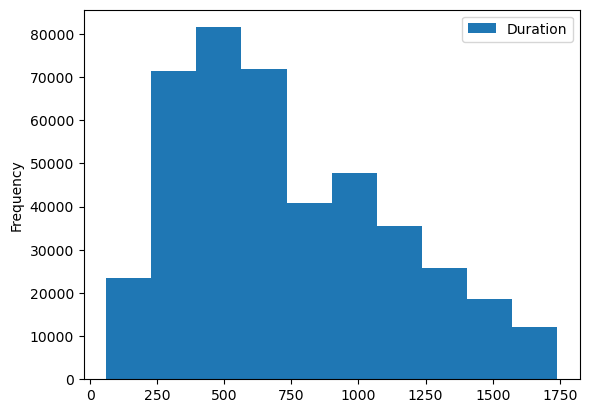

In [18]:
# try simple plot via pandas (we cover plotting again in demo#3)
import matplotlib.pyplot as plt
import pandas as pd


non_zeros_df = j_df.filter("Duration > 0")
# plot those with duration less than 1800 seconds (0.5 hrs)
pd_df = non_zeros_df.filter("Duration<1800")[["Duration"]].toPandas()
print("sample of ",pd_df.count())

pd_df.plot(kind="hist") # do without and then repeat but set #bins same as Excel (presume 94 bins)
plt.show()

In [19]:
# TO DO: determine %age of rides >3 days and interpret what this means
# TO DO: chose a different input file and compare outputs, discuss what this means (=> sim to first steps you will take in your assignment)

ideas for what we would want to do next
*   read all files and get top 10 source and top 10 dest stations
*   link with geo data to plot routes (heatmap for popularity)
*   use geo data to group (e.g. all Hyde Park as single entity)
*   compare top sites by month (or by weather (new dataset))
*   what dataset would we need to 'join' to determine safest routes?
*   can we determine popular routes by 'mode' (e.g. short, day hire, commuting etc)










>